# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

from src.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
DATA_DIR = os.path.join("..", "data", "prepared")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idatas = {
    d.replace(".json", ""): az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, d, "idata"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d))
}     
idatas["interaction"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [8]:
data = {
    n: load_prepared_data(os.path.join(DATA_DIR, n))
    for n in os.listdir(DATA_DIR)
}

ImportError: attempted relative import with no known parent package

## Comparing in and out of sample log likelihoods

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected posterior log predictive density for each inference.

It then calculates the average posterior in and out of sample log likelihoods.

In [3]:
posterior_comparison = az.compare(idatas, var_name="llik")
posterior_comparison["mean_ll_posterior"], posterior_comparison["mean_ll_kfold"] = (
    pd.Series(
        {name: idata.log_likelihood[var].mean().values for name, idata in idatas.items()}, 
        dtype="float64"
    )
    for var in ["llik", "llik_kfold"]
)
posterior_comparison.apply(lambda s: s.round(3) if s.dtype == "float64" else s)

/Users/tedgro/repos/teddygroves/hack/my_cool_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/repos/teddygroves/hack/my_cool_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/hack/my_cool_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setti

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale,mean_ll_posterior,mean_ll_kfold
fake_interaction,0,-22.399,4.034,0.000,0.982,6.858,0.000,False,log,-0.203,-0.258
no_interaction,1,-84.604,2.976,62.205,0.018,6.807,9.513,False,log,-0.831,-0.923
interaction,2,-86.335,3.865,63.935,0.000,6.611,9.410,True,log,-0.843,-0.901


The 

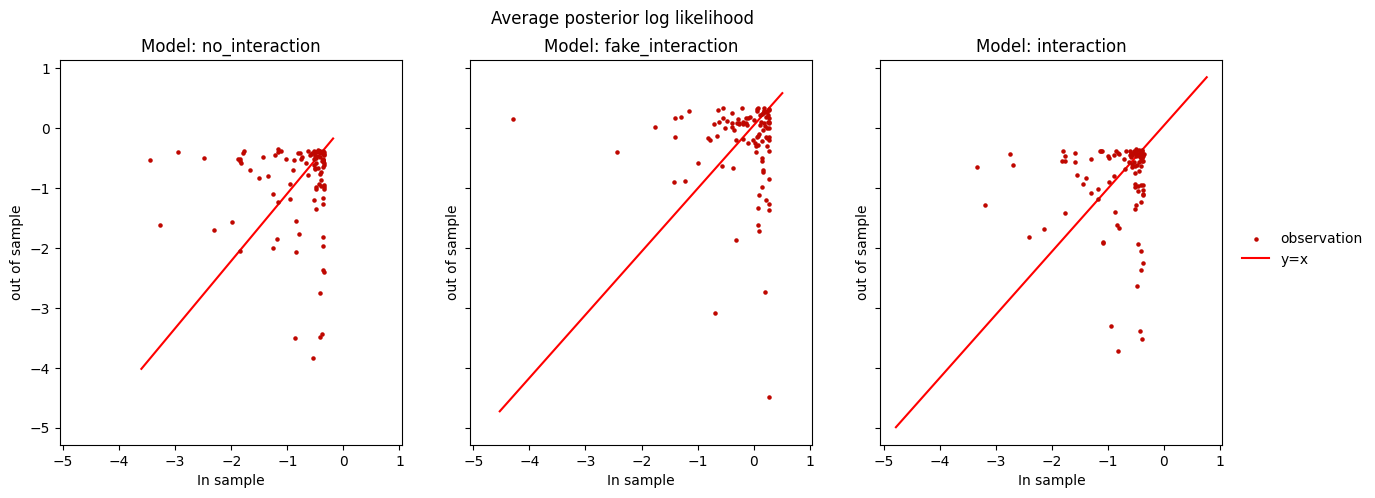

In [4]:
f, axes = plt.subplots(1, 3, figsize=[15, 5], sharex=True, sharey=True)

for ax, (name, idata) in zip(axes, idatas.items()):
    scatter = ax.scatter(
        idata.log_likelihood["llik"].mean(dim=["chain", "draw"]),
        idata.log_likelihood["llik_kfold"].mean(dim=["chain", "draw"]),
        s=5
    )
    line = ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", zorder=0)
    text = ax.set(xlabel="In sample", ylabel="out of sample", title="Model: " + name)

suptitle = f.suptitle("Average posterior log likelihood")
legend = f.legend([scatter, line[0]], ["observation", "y=x"], frameon=False, loc="right")
f.savefig(os.path.join(PLOTS_DIR, "posterior_ll_comparison.png"))

Spot the model that was used to generate the "observed" data!

## Compare posterior predictive distributions

The last cell uses arviz to plot each posterior predictive distribution and saves the result to the `plots` directory.

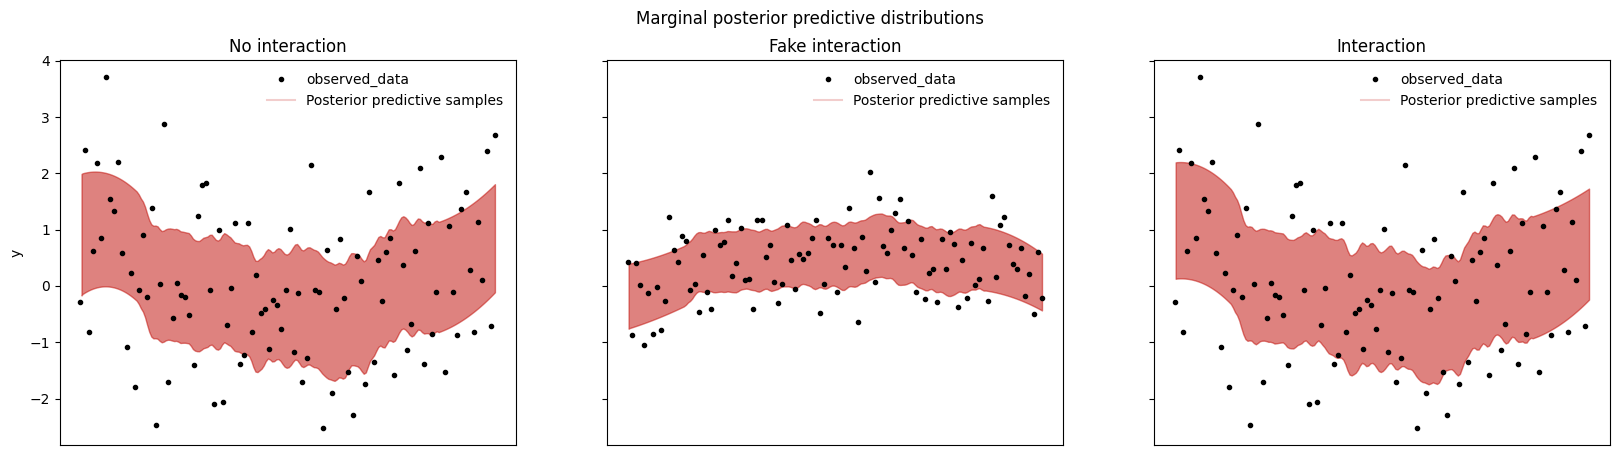

In [5]:
x = xarray.DataArray(np.linspace(0, 1, 100))
f, axes = plt.subplots(1, 3, figsize=[20, 5], sharey=True)
axes = axes.ravel()
for (name, idata), ax in zip(idatas.items(), axes):
        az.plot_lm(
            y=data[]"y",
            x=x,
            idata=idata,
            y_hat="yrep",
            axes=ax,
            kind_pp="hdi",
            y_kwargs={"markersize": 6, "color":"black"},
            grid=False
        )
        ax.legend(frameon=False)
        ax.set(title=name.replace("_", " ").capitalize(), ylabel="")
        ax.set_xticks([], [])
axes[0].set_ylabel("y")

suptitle = f.suptitle("Marginal posterior predictive distributions")
f.savefig(os.path.join(PLOTS_DIR, "posterior_predictive_comparison.png"))

In [1]:
az.plot_lm?

Object `az.plot_lm` not found.
